The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.2


# Networks Using Blocks (VGG)
:label:`sec_vgg`

While AlexNet offered empirical evidence that deep CNNs
can achieve good results, it did not provide a general template
to guide subsequent researchers in designing new networks.
In the following sections, we will introduce several heuristic concepts
commonly used to design deep networks.

Progress in this field mirrors that in chip design
where engineers went from placing transistors
to logical elements to logic blocks.
Similarly, the design of neural network architectures
had grown progressively more abstract,
with researchers moving from thinking in terms of
individual neurons to whole layers,
and now to blocks, repeating patterns of layers.

The idea of using blocks first emerged from the
[Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/) (VGG)
at Oxford University,
in their eponymously-named *VGG* network.
It is easy to implement these repeated structures in code
with any modern deep learning framework by using loops and subroutines.


## (**VGG Blocks**)
:label:`subsec_vgg-blocks`

The basic building block of classic CNNs
is a sequence of the following:
(i) a convolutional layer
with padding to maintain the resolution,
(ii) a nonlinearity such as a ReLU,
(iii) a pooling layer such
as a maximum pooling layer.
One VGG block consists of a sequence of convolutional layers,
followed by a maximum pooling layer for spatial downsampling.
In the original VGG paper :cite:`Simonyan.Zisserman.2014`,
the authors
employed convolutions with $3\times3$ kernels with padding of 1 (keeping height and width)
and $2 \times 2$ maximum pooling with stride of 2
(halving the resolution after each block).
In the code below, we define a function called `vgg_block`
to implement one VGG block.


The function takes two arguments
corresponding to the number of convolutional layers `num_convs`
and the number of output channels `num_channels`.


In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l


def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(tf.keras.layers.Conv2D(num_channels,kernel_size=3,
                                    padding='same',activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

## [**VGG Network**]

Like AlexNet and LeNet,
the VGG Network can be partitioned into two parts:
the first consisting mostly of convolutional and pooling layers
and the second consisting of fully-connected layers.
This is depicted in :numref:`fig_vgg`.

![From AlexNet to VGG that is designed from building blocks.](http://d2l.ai/_images/vgg.svg)
:width:`400px`
:label:`fig_vgg`


The convolutional part of the network connects several VGG blocks from :numref:`fig_vgg` (also defined in the `vgg_block` function)
in succession.
The following variable `conv_arch` consists of a list of tuples (one per block),
where each contains two values: the number of convolutional layers
and the number of output channels,
which are precisely the arguments required to call
the `vgg_block` function.
The fully-connected part of the VGG network is identical to that covered in AlexNet.

The original VGG network had 5 convolutional blocks,
among which the first two have one convolutional layer each
and the latter three contain two convolutional layers each.
The first block has 64 output channels
and each subsequent block doubles the number of output channels,
until that number reaches 512.
Since this network uses 8 convolutional layers
and 3 fully-connected layers, it is often called VGG-11.


In [ ]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

The following code implements VGG-11. This is a simple matter of executing a for-loop over `conv_arch`.


In [ ]:
def vgg(conv_arch):
    net = tf.keras.models.Sequential()
    # The convulational part
    for (num_convs, num_channels) in conv_arch:
        net.add(vgg_block(num_convs, num_channels))
    # The fully-connected part
    net.add(tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10)]))
    return net

net = vgg(conv_arch)

Next, we will construct a single-channel data example
with a height and width of 224 to [**observe the output shape of each layer**].


In [ ]:
X = tf.random.uniform((1, 224, 224, 1))
for blk in net.layers:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 112, 112, 64)
Sequential output shape:	 (1, 56, 56, 128)
Sequential output shape:	 (1, 28, 28, 256)
Sequential output shape:	 (1, 14, 14, 512)
Sequential output shape:	 (1, 7, 7, 512)
Sequential output shape:	 (1, 10)


As you can see, we halve height and width at each block,
finally reaching a height and width of 7
before flattening the representations
for processing by the fully-connected part of the network.

## Training

[**Since VGG-11 is more computationally-heavy than AlexNet
we construct a network with a smaller number of channels.**]
This is more than sufficient for training on Fashion-MNIST.


In [ ]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
# Recall that this has to be a function that will be passed to
# `d2l.train_ch6()` so that model building/compiling need to be within
# `strategy.scope()` in order to utilize the CPU/GPU devices that we have
net = lambda: vgg(small_conv_arch)

Apart from using a slightly larger learning rate,
the [**model training**] process is similar to that of AlexNet in :numref:`sec_alexnet`.


loss 0.177, train acc 0.934, test acc 0.919
847.6 examples/sec on /GPU:0


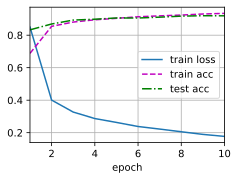

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Summary

* VGG-11 constructs a network using reusable convolutional blocks. Different VGG models can be defined by the differences in the number of convolutional layers and output channels in each block.
* The use of blocks leads to very compact representations of the network definition. It allows for efficient design of complex networks.
* In their VGG paper, Simonyan and Ziserman experimented with various architectures. In particular, they found that several layers of deep and narrow convolutions (i.e., $3 \times 3$) were more effective than fewer layers of wider convolutions.


[Discussions](https://discuss.d2l.ai/t/277)
